In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

#### 분류 모델이란?
본격적인 모델 설명에 앞서, '분류'라는 개념 자체에 대한 개념을 정립하자.

    학습 데이터로 주어진 feature, label을 학습해 모델 생성 후,
    새로운 feature에 대해 미지의 label 값을 예측해 판별하는 것
    
- 이진 분류: 0(Negative)과 1(Positive), 2개의 결과값만 지니는 분류(ex. 타이타닉 생존 예측)
- 멀티 분류: 여러 개의 결정값을 지니는 분류(ex. 붓꽃 품종 예측)


이하의 성능 평가 지표는 특히 이진 분류에서 그 중요도가 커진다.  
  

##### 분류의 성능 평가 지표 - 모두 sklearn.metrics에서 import 가능
- 정확도(Accuracy)
    - 실제 데이터에서 예측 데이터가 얼마나 잘 들어맞았는지에 대한 비율
    - accuracy_score(y, y_pred)
    - 정확도$=\frac{TP+TN}{TP+TN+FP+FN}$
    
- 오차행렬(Confusion Matrix)
    - 이진 분류에서 오류가 얼마나 일어나는지, 어떤 유형의 오류가 일어나는지 동시에 보여줌
    - confusion_matrix(y, y_pred)
        - TN: 실제도 0, 예측도 0
        - FP: 실제는 0, 예측은 1
        - FN: 실제는 1, 예측은 0
        - TP: 실제도 1, 예측도 1
        
        
- 정밀도(Precision)
    - 1로 예측한 것 중 얼마나 실제로 1인지에 대한 비율
    - precision_score(y, y_pred)
    - 정밀도$=\frac{TP}{TP+FP}$
    - 전부 다 0(Negative)으로 예측하거나, 100% 확실한 것만 1로 예측하면  
    FP=0 → 정밀도는 1이 된다.
    - 실제 0인 것을 1로 보면 안 될 때 중요해짐 → 스팸 메일 분류 등
    
    
- 재현율(Recall, 민감도, TPR)
    - 실제 1인 것을 얼마나 1로 예측하는지에 대한 비율
    - recall_score(y, y_pred)
    - 재현율$=\frac{TP}{TP+FN}$
    - 전부 다 1(Positive)로 예측하면 FN=0 → 재현율은 1이 된다.
    - 실제 1인 것을 0으로 보면 안 될 때 중요해짐 → 금융 사기 판별 등
    
    
- F1 스코어(F1 Score)
    - 정밀도와 재현율 둘 중 어느 쪽으로도 치우치지 않을 때 높은 값을 가짐.
    - f1_score(y, y_pred)
    - F1 Score$=\frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}}=2*\frac{정밀도*재현율}{정밀도+재현율}$
    
    
- ROC AUC 스코어
    - FPR이 변할 때 TPR(재현율, 민감도)이 변하는 추이를 그려낸 곡선의 아랫 면적.  
    1에 가까울수록 좋은 수치.
    - roc_auc_score(y, y_pred_proba)
    - 가로축 $FPR=\frac{FP}{FP+TN}=1-\frac{TN}{FP+TN}=1-TNR(특이성)$
    - 세로축 $TPR=\frac{TP}{TP+FN}$
    - 여기서 인자로 사용되는 y_pred_proba는 predict_proba(X_test)[:,1]임(예측값이 1일 확률 배열)

In [2]:
def evaluation(y, pred=None, prob=None):
    accuracy = accuracy_score(y, pred)
    confusion = confusion_matrix(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)
    auc = roc_auc_score(y, prob)
    
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f},\
F1 스코어: {f1:.4f}, ROC AUC 스코어: {auc:.4f}')
    print(f'오차행렬:\n{confusion}')
    print(f'TN: {confusion[0,0]}, FP {confusion[0,1]}\n\
FN: {confusion[1,0]}, TP: {confusion[1,1]}')

#### 거 자꾸 과대적합, 과소적합 하는데 대체 이게 뭔가요?

##### 과대적합(Overfitting)
    학습/훈련 데이터에 최적화 되어 실제 테스트 데이터에서의 예측 성능이 떨어지는 현상.
    모델이 지나치게 복잡하게 구성되어 있을 경우 과대적합이 발생할 가능성이 높기 때문에,
    데이터 잡음(이상치)을 제거하고 정규화를 거치는 등 전처리를 통해 모델의 복잡도를 낮춰야 한다.

##### 과소적합(Underfitting)
    학습/훈련 데이터를 제대로 학습하지 못해서 학습 데이터에서조차 예측 성능이 떨어지는 현상.
    모델이 지나치게 단순하게 구성되어 있을 경우 과소적합이 발생할 가능성이 높기 때문에,
    다양한 파라미터 설정, 과도하게 높은 제약 조건 완화, 충분한 학습시간 등을 부여해 모델의 복잡도를 높여야 한다.
    
##### 하이퍼파라미터(Hyperparameter) - 규제
    모델에 추가적으로 사람이 걸 수 있는 여러 제약조건.
    학습 전에 미리 부여하며 모델의 영향을 받지 않는다.
    하이퍼파라미터의 값이 높을수록 모델은 단순화되며 과소적합의 가능성이 커진다.
    GridSearchCV 등의 모델을 사용해 최적의 파라미터를 찾아보자.

### 의사결정 나무(Decision Tree Classifier)
    규칙 조건마다 분기를 만들어 분류하는, 가장 직관적이며 기본적인 분류 알고리즘.
    규칙이 세분화될수록 트리는 복잡해지고 과대적합이 되기 쉽다.
    트리의 말단부를 리프 노드(잎사귀)라 부르며, 이곳에 결정값이 위치한다.
#### from sklearn.tree import DecisionTreeClassifier

- $정보 이득 지수 = 1 - 엔트로피$
- 지니 계수: 불평등한 정도를 나타내는 지수. 0이 가장 평등, 1이 가장 불평등.
- 균일도란 동일한 데이터가 많을수록 높아지므로  
엔트로피와 지니 계수가 낮고, 정보 이득 지수가 높을 때 균일도가 높아진다.
- 데이터 꾸러미에서 가장 균일도가 높은 부분을 먼저 떼어낼 수 있도록 하는 것이 관건.  
즉, 가장 쉽게 예측할 수 있는 조건을 규칙 노드로 설정한다.  

##### 의사결정 나무 파라미터
- min_samples_split (기본값: 2)
    - 분기로 가를 수 있는 최소한의 샘플 데이터 수.
    - 작을수록 세세하게 노드를 나눌 수 있기 때문에 과대적합 가능성이 증가한다.
    - 너무 커도 예측 성능이 떨어지니 적절한 수치로 제어해야 함.

- min_samples_leaf
    - 리프 노드(트리의 최말단부)가 될 수 있는 최소한의 샘플 데이터 수.
    - 이것 역시 작을수록 잎사귀가 세세하게 나뉘기 때문에 과대적합 제어 용도로 씀.
    - 단, 비대칭적 데이터는 특정 데이터의 수가 부족하므로 작게 설정해야 예측 성능을 높일 수 있다.

- max_features (기본값: None, 데이터의 모든 feature 사용)
    - 분할할 때 고려하는 최대 feature 개수.
    - int형: 대상 feature의 개수
    - float형: 전체 feature에서 대상 feature의 퍼센트 비율
    - sqrt, auto: $\sqrt{전체 feature 개수}$
    - log: $log_{2}$(전체 feature 개수)
    - None: 전체 feature 대상

- max_depth (기본값: None, 완벽한 분류가 되거나 min_samples_split 제한에 걸릴 때까지 계속 분할)
    - 트리의 깊이를 결정하는 파라미터.
    - 높을수록 트리가 복잡해지므로 적절한 값으로 설정해야 과대적합의 위험을 줄일 수 있다.

- max_leaf_nodes
    - 리프 노드의 최대 개수.
    - 근데 이것보단 다른 직관적이고 효율 좋은 파라미터가 많으니 그걸 조정합쉬다.

In [3]:
# 붓꽃 품종 예측 데이터로 실습해 봅시다.
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print(f'테스트 데이터에서의 정확도: {accuracy_score(y_test, pred).round(4)}')

테스트 데이터에서의 정확도: 0.9556


In [4]:
# 파이썬 기반 시각화


In [5]:
# 최적 파라미터도 찾아 볼까용?
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(dtc,
                   param_grid = {'max_depth':[2,3,5],
                                'min_samples_split':[2,3,5]},
                   scoring = 'accuracy', cv = 5)
grid.fit(X_train, y_train)
print(f'최고 평균 정확도: {grid.best_score_:.4f}')
print(f'최적 하이퍼 파라미터: {grid.best_params_}')
bestpr = grid.best_estimator_.predict(X_test)
print(f'테스트 데이터에서의 최고 정확도: {accuracy_score(y_test,bestpr):.4f}')
# 사실 우리는 알고 있다. 트리의 깊이가 깊고 분기가 세세할수록 정확도는 높아진다는 것을... ^오T

최고 평균 정확도: 0.9429
최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_split': 2}
테스트 데이터에서의 최고 정확도: 0.9556


In [6]:
# 이진 분류용 타이타닉 데이터셋도 만들어 보자. 대충 ^^
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
df = pd.read_csv('./dataset/train.csv')
df.drop(['PassengerId', 'Name', 'Ticket','Fare','Cabin'],axis=1, inplace=True)
df.Embarked.fillna('S', inplace=True)
df.Age.fillna(df.Age.mean(), inplace=True)
le = LabelEncoder()
for i in ['Sex', 'Embarked']:
    df[i] = le.fit_transform(df[i])
scaler = MinMaxScaler()
df.Age = scaler.fit_transform(df[['Age']])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,0.271174,1,0,2
1,1,1,0,0.472229,1,0,0
2,1,3,0,0.321438,0,0,2
3,1,1,0,0.434531,1,0,2
4,0,3,1,0.434531,0,0,2


In [7]:
X = df.drop('Survived', axis=1)
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
prob = dtc.predict_proba(X_test)[:,1]
evaluation(y_test, pred, prob)

정확도: 0.8212, 정밀도: 0.7593, 재현율: 0.6833,F1 스코어: 0.7193, ROC AUC 스코어: 0.7637
오차행렬:
[[106  13]
 [ 19  41]]
TN: 106, FP 13
FN: 19, TP: 41


# 앙상블 학습(Ensemble Learning)
#### 보팅(Voting)
    여러 ML 알고리즘 분류기가 같은 데이터를 학습한 후 예측한 결과를 가지고 보팅,
    최종 예측 결과를 선정하는 방식.
- 하드 보팅(Hard Voting)  
: 예측한 결과값 중 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정.
- 소프트 보팅(Soft Voting)  
: 분류기들의 레이블 값 결정 확률을 모두 더해 평균을 내 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정. 일반적으로 소프트 보팅이 보팅 방법으로 적용됨.

#### 배깅(Bagging)
    단일 ML 알고리즘 여러 개로 원본 데이터에서 추출한 샘플링 데이터를 학습.
    개별 분류기 객체에 할당된 샘플링 데이터를 학습한 후 보팅을 통해 최종 결과값을 선정.
    교차 검증의 경우 데이터 세트 간 중복을 허용하지 않으나 배깅 방식은 중첩을 허용한다.
    대표적인 배깅 앙상블 알고리즘이 바로 랜덤 포레스트(의사결정 나무 여러 개를 심는 느낌).
#### 부스팅(Boosting)
    여러 개의 약한 분류기로 순차적 학습을 수행하되, 앞서 학습한 분류기의 예측이 틀렸던 데이터에 대해서는 다음 분류기에 가중치를 부여해 올바르게 예측할 수 있도록 하는 방식.
    대표적인 부스팅 모듈로는 GBM, XGB, LightGBM이 있음.

### 랜덤 포레스트(Random Forest)
    중첩을 허용한 샘플링 데이터 세트에 대해 개별적으로 의사결정 나무 알고리즘을 적용해 학습한 후, 모든 분류기가 보팅을 통해 최종 결과값을 선정하는 방식.
    (의사결정 나무(Decision Tree)를 여럿 심어 랜덤한 숲(Random Forest)을 만든다고 생각하면 쉽다.)
#### from sklearn.ensemble import RandomForestClassifier
- 트리 기반 앙상블 알고리즘의 고질적인 문제로, 하이퍼 파라미터가 너무 많아 튜닝에 소모되는 시간이 많음(그나마 랜덤 포레스트가 적은 편)

##### 랜덤 포레스트 파라미터
- n_estimators (기본값: 10)
    - 결정 트리의 개수를 지정.
    - 많이 심을수록 성능 향상을 기대할 수는 있지만 항상 비례하는 것은 아님.
    - 그런데 늘리면 학습 수행 시간도 오래 걸림. ㅋㅋ.
    
- max_features (기본값: sqrt)
    - 결정 트리의 max_features 파라미터와 동일한 역할을 수행. 값 지정도 동일함.
    - 다만 기본값이 None이 아니라 sqrt(auto)라, 전체 데이터 feature가 16개라면 $\sqrt{16}$인 4개의 데이터만 참조하게 된다.

- 그 외 max_depth, min_samples_split, min_samples_leaf 등 과적합 제어용 파라미터가 랜덤 포레스트에서도 동일하게 적용된다.

In [8]:
# 아까 썼던 타이타닉 데이터를 랜덤 포레스트로 예측해 볼까?
from sklearn.ensemble import RandomForestClassifier
X = df.drop('Survived', axis=1)
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
prob = rf.predict_proba(X_test)[:,1]
evaluation(y_test, pred, prob)
# 단일 의사결정 나무의 결과값
# 정확도: 0.8212, 정밀도: 0.7593, 재현율: 0.6833,F1 스코어: 0.7193, ROC AUC 스코어: 0.7756
# 보다 전체적으로 향상된 값을 보여주고 있다.

정확도: 0.8436, 정밀도: 0.7759, 재현율: 0.7500,F1 스코어: 0.7627, ROC AUC 스코어: 0.8589
오차행렬:
[[106  13]
 [ 15  45]]
TN: 106, FP 13
FN: 15, TP: 45


,feature_value
Age,0.385580
Sex,0.308427
Pclass,0.126232
SibSp,0.078945
Parch,0.053097
Embarked,0.047719


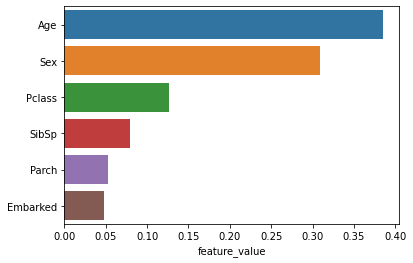

In [9]:
# 피처 중요도 추출 및 시각화
imp = pd.DataFrame(rf.feature_importances_,
                   index=X_train.columns,
                   columns=['feature_value']).sort_values(by='feature_value',ascending=False)
display(imp)
sns.barplot(x = imp.feature_value, y = imp.index)
plt.show()

In [10]:
# 붓꽃 데이터를 하이퍼 파라미터 튜닝하여 예측한다면?
iris = load_iris()
X = iris.data
y = iris.target

X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.3,random_state=123)
rf2 = RandomForestClassifier()
grid = GridSearchCV(rf2, param_grid={'max_depth':[1,3,5],
                                   'n_estimators':[100],
                                   'min_samples_split':[2,4,6]}, cv=3)
grid.fit(X_train1,y_train1)
print(f'최고 평균 정확도: {grid.best_score_:.4f}')
print(f'최적 하이퍼 파라미터: {grid.best_params_}')
bestpr = grid.best_estimator_.predict(X_test1)
print(f'테스트 데이터에서의 최고 정확도: {accuracy_score(y_test1,bestpr):.4f}')

최고 평균 정확도: 0.9333
최적 하이퍼 파라미터: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 100}
테스트 데이터에서의 최고 정확도: 0.9556


In [27]:
# cvs를 이용한 교차검증 수행
score = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=5)
for i in range(len(score)):
    print(f'{i+1}번째 검증 정확도: {score[i]:.4f}')

1번째 검증 정확도: 0.9560
2번째 검증 정확도: 0.9780
3번째 검증 정확도: 0.9780
4번째 검증 정확도: 0.9670
5번째 검증 정확도: 0.9231


### GBM(Gradient Boosting Machine)
    경사하강법(Gradient Descent)을 이용해 오류를 줄이는 방향으로 반복 수행하는 부스팅 알고리즘. 분류기 성능이 약해도 반복 수행으로 보완할 수 있으나, 시간이 아주 오래 걸림. 순차적 수행이라 병렬 연산이 안 되기 때문임.

#### from sklearn.ensemble import GradientBoostingClassifier


##### GBM 파라미터
- loss (기본값: deviance)
    - 경사하강법에서 사용할 비용 함수 지정
    
- learning_rate (기본값: 0.1)
    - 학습을 진행할 때마다 적용하는 학습률. 약한 분류기가 순차적으로 오류값을 보정해 나갈 때 사용하는 계수.
    - 작게 설정하면 섬세한 보정이 가능해지지만 시간이 엄청 오래 걸리고, 반복이 완료될 때까지 최소 오류값에 도달 못할 가능성도 생김.
    - 크게 설정하면 최소 오류값이 남았음에도 지나칠 수 있어 예측 성능이 떨어지지만, 수행 시간은 단축됨.
    - n_estimators와 상호보완적으로 사용 가능. 세세한 학습률, 많은 분류기로 예측 성공률을 높일 수 있지만 시간이... 시간이 엄청 걸림. 농담 아님.

- n_estimators (기본값: 100)
    - 약한 분류기의 개수. 순차적으로 학습을 수행하므로 많을수록 시간 오래 걸림.

- subsample (기본값: 1)
    - 약한 분류기가 학습에 사용하는 데이터의 샘플링 비율.
    - 소수점으로 퍼센티지를 나타냄(0.5를 지정하면 전체 데이터의 50%를 샘플링).
    - 과대적합의 우려가 있을 때에는 1(전체 데이터)보다 작은 값으로 설정하면 됨.

In [11]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
can = pd.DataFrame(cancer.data, columns=cancer.feature_names)
can['target'] = cancer.target
can.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
print(cancer.target_names,'\n',can.target.value_counts())

['malignant' 'benign'] 
 1    357
0    212
Name: target, dtype: int64


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=12)
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
pred = gbm.predict(X_test)
print(f'정확도: {accuracy_score(y_test, pred):.4f}')

정확도: 0.9386


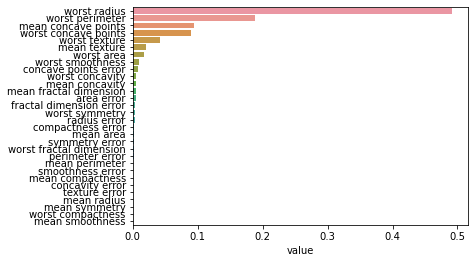

In [14]:
imp = pd.DataFrame(gbm.feature_importances_, index=X_train.columns, columns=['value'])
imp.sort_values(by='value', ascending=False, inplace=True)
sns.barplot(x=imp.value, y=imp.index)
plt.show()

In [15]:
gr = GridSearchCV(gbm, param_grid={'learning_rate':[0.3,0.5,1],
                                  'n_estimators':[100,300]}, cv=5, scoring='accuracy')
gr.fit(X_train, y_train)
pred = gr.best_estimator_.predict(X_test)
print(f'최적 파라미터: {gr.best_params_}')
print(f'최고 평균 정확도: {gr.best_score_:.4f}')
print(f'최적 파라미터로 테스트 데이터 예측 정확도: {accuracy_score(y_test,pred):.4f}')

최적 파라미터: {'learning_rate': 0.3, 'n_estimators': 100}
최고 평균 정확도: 0.9714
최적 파라미터로 테스트 데이터 예측 정확도: 0.9386


### XGBoost(eXtra Gradient Boosting)
    GBM 기반이지만 GBM의 단점인 느린 수행 시간과 과대적합 부분을 개선한 부스팅 알고리즘. 병렬 학습이 가능해 GBM 대비 학습 시간이 빠른 것이 특징(물론 GBM 대비해서 그럴 뿐이고, 속도는 Random Forest나 LightGBM이 더 빠르다.).

#### import xgboost as xgb (파이썬 기반)
#### from xgboost import XGBClassifier (사이킷런 기반, 분류용)
#### from xgboost import XGBRegressor (사이킷런 기반, 회귀용)
- 사이킷런 산하 모듈이 아니기 때문에 별도로 설치해야 함.
- 사용할 때는 사이킷런 래퍼 모듈 쓸 거임. 그게 사이킷런 관련 파라미터랑 호환됨.


##### XGB 하이퍼 파라미터
- early_stopping_rounds
    - 조기 중단 파라미터. 미입력 시 조기 중단 기능 비활성화.
    - 입력값만큼 반복하면서 그동안 성능 평가가 개선되지 않으면 반복 중단함.  
    시간 단축은 되지만 예측 성능이 떨어질 수 있다.
- 그 외 n_estimators, learning_rate, max_depth 등 여러 파라미터 공유

In [16]:
# 위스콘신 유방암 다시 가져오자
from xgboost import XGBClassifier
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=11)
xgb = XGBClassifier(n_estimators=5, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
       eval_set=[(X_test, y_test)], verbose=True)
pred = xgb.predict(X_test)
prob = xgb.predict_proba(X_test)[:,1]
evaluation(y_test, pred, prob)

[0]	validation_0-logloss:0.61282
[1]	validation_0-logloss:0.54112
[2]	validation_0-logloss:0.48139
[3]	validation_0-logloss:0.42984
[4]	validation_0-logloss:0.38936
정확도: 0.9825, 정밀도: 0.9868, 재현율: 0.9868,F1 스코어: 0.9868, ROC AUC 스코어: 0.9981
오차행렬:
[[37  1]
 [ 1 75]]
TN: 37, FP 1
FN: 1, TP: 75


In [17]:
# 만약 조기종료를 한다면 예측 성능은 얼마나 떨어질까?
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=11)
xgb = XGBClassifier(n_estimators=5, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_metric='logloss',
       eval_set=[(X_test, y_test)], verbose=True)
pred = xgb.predict(X_test)
prob = xgb.predict_proba(X_test)[:,1]
evaluation(y_test, pred, prob)

# 왜 차이가 없냐...? 객체도 새로 선언했는데 ㅠㅠ... 아마 데이터 개수가 별로 없어서 그런 듯.

[0]	validation_0-logloss:0.61282
[1]	validation_0-logloss:0.54112
[2]	validation_0-logloss:0.48139
[3]	validation_0-logloss:0.42984
[4]	validation_0-logloss:0.38936
정확도: 0.9825, 정밀도: 0.9868, 재현율: 0.9868,F1 스코어: 0.9868, ROC AUC 스코어: 0.9981
오차행렬:
[[37  1]
 [ 1 75]]
TN: 37, FP 1
FN: 1, TP: 75


### LightGBM
    일반 GBM 계열의 '균형 트리 분할(Level Wise)' 방식과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용하여, 트리들의 깊이가 제각각이고 비대칭적인 규칙 트리를 생성한다.
    LightGBM의 트리 생성 규칙은 '최대 손실 값(max delta loss)'을 갖는 잎사귀를 분할 대상으로 삼고 해당 노드를 지속적으로 분할하면서 예측 오류 손실을 최소화 시키는 것이다.

#### from lightgbm import LGBMClassifier
- 통상 1만 건 이하의 데이터 세트에 적용할 경우 과대적합이 발생할 가능성이 높아진다.

##### LightGBM 하이퍼 파라미터
- min_child_samples (기본값: 20)
    - min_samples_leaf와 같은 기능. 말단 노드가 될 수 있는 최소 크기.

- num_leaves (기본값: 31)
    - 하나의 트리가 가질 수 있는 최대 리프 개수.

In [18]:
# 위스콘신 유방암 또 써먹어 볼까?
from lightgbm import LGBMClassifier
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=11)
lgbm = LGBMClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_metric='logloss',
       eval_set=[(X_test, y_test)], verbose=True)
pred = lgbm.predict(X_test)
prob = lgbm.predict_proba(X_test)[:,1]
evaluation(y_test, pred, prob)

[1]	valid_0's binary_logloss: 0.566087
[2]	valid_0's binary_logloss: 0.501195
[3]	valid_0's binary_logloss: 0.445904
[4]	valid_0's binary_logloss: 0.39994
[5]	valid_0's binary_logloss: 0.363233
[6]	valid_0's binary_logloss: 0.328873
[7]	valid_0's binary_logloss: 0.298449
[8]	valid_0's binary_logloss: 0.27205
[9]	valid_0's binary_logloss: 0.250738
[10]	valid_0's binary_logloss: 0.23006
정확도: 0.9649, 정밀도: 0.9500, 재현율: 1.0000,F1 스코어: 0.9744, ROC AUC 스코어: 1.0000
오차행렬:
[[34  4]
 [ 0 76]]
TN: 34, FP 4
FN: 0, TP: 76


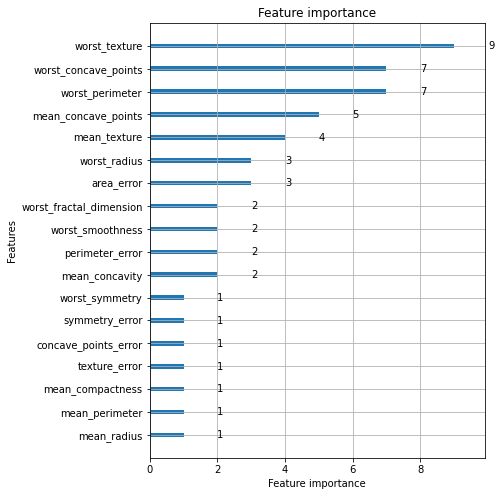

In [19]:
# 이건 자체 시각화 기능이 있어. 짱이지?
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(6,8))
plot_importance(lgbm, ax=ax)
plt.show()

In [20]:
# 이건 회귀에 썼던 모델..같기도.....
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

bs = load_boston()
boston = pd.DataFrame(bs.data, columns=bs.feature_names)
boston = boston[['ZN', 'INDUS', 'NOX', 'RM', 'RAD','PTRATIO', 'B', 'LSTAT']]
boston['PRICE'] = bs.target
boston.head()

,ZN,INDUS,NOX,RM,RAD,PTRATIO,B,LSTAT,PRICE
0,18.0,2.31,0.538,6.575,1.0,15.3,396.90,4.98,24.0
1,0.0,7.07,0.469,6.421,2.0,17.8,396.90,9.14,21.6
2,0.0,7.07,0.469,7.185,2.0,17.8,392.83,4.03,34.7
3,0.0,2.18,0.458,6.998,3.0,18.7,394.63,2.94,33.4
4,0.0,2.18,0.458,7.147,3.0,18.7,396.90,5.33,36.2
